# Experiments


## Notes

* Prerequisites
    * `pip3 install torch == 1.2.0`
    * `pip3 install gym == 0.23.1`
    * `pip3 install mujoco == 2.2.1`
* For lunar lander    
    * `conda install swig`
    * `pip3 install box2d-py`
* if there's a`mujoco_py does not exist` error, on the `gym` and/or `d4rl` package, import `mujoco as mujoco_py`
    * ~/anaconda3/envs/plas/lib/python3.7/site-packages/gym/envs/mujoco/mujoco_env.py
    * ~/anaconda3/envs/plas/lib/python3.7/site-packages/gym/envs/mujoco/pusher.py


* Pybullet datasets reference
    * https://github.com/takuseno/d4rl-pybullet
    * https://github.com/Farama-Foundation/D4RL/tree/f2a05c0d66722499bf8031b094d9af3aea7c372b
    
* PLAS algorithm
    * https://github.com/Wenxuan-Zhou/PLAS
* Gym documentation
    * https://www.gymlibrary.dev/environments/mujoco/walker2d/

## Packages

In [77]:
import gym
env_name = "LunarLander-v2"
env = gym.make(
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5, # between 0 and 20
    turbulence_power = 1, # between 0 and 2
)

In [2]:
"""
Based on https://github.com/sfujim/BCQ
"""
import argparse
import numpy as np
import os
import pickle
import utils
import algos
from logger import logger, setup_logger
# import d4rl
import torch
import time
from eval_functions import eval_critic
import shutil
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force cpu
# device = torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3070 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


'NVIDIA GeForce RTX 3070'

## Gym Environments

In [4]:
# print(gym.envs.registry.all())

## Inputs

In [5]:
# %tb
# ORIGINAL INPUTS

# parser = argparse.ArgumentParser()

# # Additional parameters
# parser.add_argument("--ExpID", default=1, type=int)              # Experiment ID
# parser.add_argument('--log_dir', default='./results/', type=str)    # Logging directory
# parser.add_argument("--load_model", default=None, type=str)         # Load model and optimizer parameters
# parser.add_argument("--save_model", default=True, type=bool)        # Save model and optimizer parameters
# parser.add_argument("--save_freq", default=1e5, type=int)           # How often it saves the model
# #parser.add_argument("--env_name", default="walker2d-medium-v0")     # OpenAI gym environment name
# parser.add_argument("--env_name", default='bullet-walker2d-medium-v0')     # OpenAI gym environment name
# parser.add_argument("--algo_name", default="Latent")                # Algorithm: Latent or LatentPerturbation.
# parser.add_argument("--dataset", default=None, type=str)            # path to dataset if not d4rl env
# parser.add_argument("--seed", default=0, type=int)                  # Sets Gym, PyTorch and Numpy seeds
# parser.add_argument("--eval_freq", default=1e3, type=int)           # How often (time steps) we evaluate
# parser.add_argument("--max_timesteps", default=5e5, type=int)       # Max time steps to run environment for
# parser.add_argument('--vae_mode', default='train', type=str)		# VAE mode: train or load from a specific version
# parser.add_argument('--vae_lr', default=1e-4, type=float)		    # vae training iterations
# parser.add_argument('--vae_itr', default=500000, type=int)		    # vae training iterations
# parser.add_argument('--vae_hidden_size', default=750, type=int)		# vae training iterations
# parser.add_argument('--max_latent_action', default=2., type=float)  # max action of the latent policy
# parser.add_argument('--phi', default=0., type=float)	            # max perturbation
# parser.add_argument('--batch_size', default=100, type=int)	        # batch size
# parser.add_argument('--actor_lr', default=1e-4, type=float)	        # policy learning rate
# parser.add_argument('--critic_lr', default=1e-3, type=float)	    # policy learning rate
# parser.add_argument('--tau', default=0.005, type=float)	            # actor network size

# # args = parser.parse_args()
# args = parser.parse_args("")

In [6]:
%tb

div = 10

parser = argparse.ArgumentParser()

# Additional parameters
parser.add_argument("--ExpID", default=2, type=int)                      # Experiment ID
parser.add_argument('--log_dir', default='./results/', type=str)         # Logging directory
parser.add_argument("--load_model", default=None, type=str)              # Load model and optimizer parameters
parser.add_argument("--save_model", default=True, type=bool)             # Save model and optimizer parameters
parser.add_argument("--save_freq", default=1e3//div, type=int)           # How often it saves the model
parser.add_argument("--env_name", default=env_name)   # OpenAI gym environment name
parser.add_argument("--algo_name", default="Latent")                     # Algorithm: Latent or LatentPerturbation.
parser.add_argument("--dataset", default=None, type=str)                 # path to dataset if not d4rl env
parser.add_argument("--seed", default=0, type=int)                       # Sets Gym, PyTorch and Numpy seeds
parser.add_argument("--eval_freq", default=1e3//div, type=int)           # How often (time steps) we evaluate
parser.add_argument("--max_timesteps", default=5e3, type=int)            # Max time steps to run environment for
parser.add_argument('--vae_mode', default='train', type=str)		     # VAE mode: train or load from a specific version
parser.add_argument('--vae_lr', default=1e-4, type=float)                # vae training iterations
parser.add_argument('--vae_itr', default=500000//div, type=int)		     # vae training iterations
parser.add_argument('--vae_hidden_size', default=128, type=int)		     # vae training iterations
parser.add_argument('--max_latent_action', default=2., type=float)       # max action of the latent policy
parser.add_argument('--phi', default=0., type=float)	                 # max perturbation
parser.add_argument('--batch_size', default=100, type=int)	             # batch size
parser.add_argument('--actor_lr', default=1e-4, type=float)	             # policy learning rate
parser.add_argument('--critic_lr', default=1e-3, type=float)	         # policy learning rate
parser.add_argument('--tau', default=0.005, type=float)	                 # actor network size

# args = parser.parse_args()
args = parser.parse_args("")

No traceback available to show.


## Setup

### Folders, Logging

In [7]:
# # delete results
# if os.path.isdir('./results'):
#     shutil.rmtree('./results/')

In [8]:
if args.dataset is None:
    args.dataset = args.env_name

# Setup Logging
file_name = f"Exp{args.ExpID:04d}_{args.algo_name}_{args.dataset}-{args.seed}"
folder_name = os.path.join(args.log_dir, file_name)
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
print(folder_name)
if os.path.exists(os.path.join(folder_name, 'variant.json')):
    shutil.rmtree(folder_name)
variant = vars(args)
variant.update(node=os.uname()[1])
setup_logger(os.path.basename(folder_name), variant=variant, log_dir=folder_name)

./results/Exp0002_Latent_LunarLander-v2-0
2022-09-05 23:04:41.418493 PST | Variant:
2022-09-05 23:04:41.418821 PST | {
  "ExpID": 2,
  "log_dir": "./results/",
  "load_model": null,
  "save_model": true,
  "save_freq": 100.0,
  "env_name": "LunarLander-v2",
  "algo_name": "Latent",
  "dataset": "LunarLander-v2",
  "seed": 0,
  "eval_freq": 100.0,
  "max_timesteps": 5000.0,
  "vae_mode": "train",
  "vae_lr": 0.0001,
  "vae_itr": 50000,
  "vae_hidden_size": 128,
  "max_latent_action": 2.0,
  "phi": 0.0,
  "batch_size": 100,
  "actor_lr": 0.0001,
  "critic_lr": 0.001,
  "tau": 0.005,
  "node": "computer"
}


'./results/Exp0002_Latent_LunarLander-v2-0'

### Environment

In [9]:
# Setup Environment

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# Set seeds
env.seed(args.seed)
env.action_space.seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# check
print(env)
print(state_dim)
print(action_dim)
print(max_action)

<TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>>
8
2
1.0


/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


## Load Dataset

In [10]:
import joblib
dataset = joblib.load('lunar_lander_data_1.joblib')

In [11]:
# # Load Dataset
# if args.env_name == args.dataset:
#     dataset = d4rl.qlearning_dataset(env)  # Load d4rl dataset
# else:
#     if args.dataset == 'hopper-medium-expert':
#         dataset1 = d4rl.qlearning_dataset(gym.make('hopper-medium-v0'))
#         dataset2 = d4rl.qlearning_dataset(gym.make('hopper-expert-v0'))
#         dataset = {key:np.concatenate([dataset1[key], dataset2[key]]) for key in dataset1.keys()}
#         print("Loaded data from hopper-medium-v0 and hopper-expert-v0")
#     else:
#         dataset_file = os.path.dirname(os.path.abspath(__file__)) + '/dataset/'+args.dataset + '.pkl'
#         dataset = pickle.load(open(dataset_file,'rb'))
#         print("Loaded data from "+dataset_file)

In [12]:
type(dataset)

dict

In [13]:
print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['terminals'].shape)

(1000000, 8)
(1000000, 2)
(1000000,)
(1000000,)


In [14]:
dataset

{'observations': array([[-0.00364981,  1.401389  , -0.3695014 , ...,  0.08013613,
          0.        ,  0.        ],
        [-0.00738592,  1.3919297 , -0.37510854, ...,  0.02964405,
          0.        ,  0.        ],
        [-0.01107321,  1.383275  , -0.36796576, ..., -0.01498931,
          0.        ,  0.        ],
        ...,
        [ 0.10738926, -0.00902727, -0.04648383, ..., -0.10661718,
          1.        ,  1.        ],
        [ 0.10695448, -0.00927435, -0.04161075, ..., -0.03685624,
          1.        ,  1.        ],
        [ 0.10659828, -0.00905917, -0.03723424, ...,  0.03204504,
          1.        ,  1.        ]], dtype=float32),
 'actions': array([[ 1.        ,  1.        ],
        [ 1.        ,  1.        ],
        [ 1.        ,  0.9151318 ],
        ...,
        [-1.        , -0.6293514 ],
        [-1.        , -0.53526896],
        [-1.        , -0.4203244 ]], dtype=float32),
 'next_observations': array([[-0.00738592,  1.3919297 , -0.37510854, ...,  0.02964405

In [15]:
dataset['terminals']

array([False, False, False, ..., False, False, False])

In [16]:
pd.DataFrame(dataset['observations'])

,0,1,2,3,4,5,6,7
0,-0.003650,1.401389,-0.369501,-0.423611,0.004054,0.080136,0.0,0.0
1,-0.007386,1.391930,-0.375109,-0.420409,0.005536,0.029644,0.0,0.0
2,-0.011073,1.383275,-0.367966,-0.384654,0.004786,-0.014989,0.0,0.0
3,-0.014780,1.375460,-0.367659,-0.347339,0.001823,-0.059271,0.0,0.0
4,-0.018521,1.367763,-0.369103,-0.342062,-0.003140,-0.099267,0.0,0.0
...,...,...,...,...,...,...,...,...
999995,0.108483,-0.007122,-0.045787,-0.076514,-0.045269,-0.260364,1.0,1.0
999996,0.107908,-0.008315,-0.048473,-0.053323,-0.054214,-0.178912,1.0,1.0
999997,0.107389,-0.009027,-0.046484,-0.031862,-0.059546,-0.106617,1.0,1.0
999998,0.106954,-0.009274,-0.041611,-0.011058,-0.061390,-0.036856,1.0,1.0


In [17]:
pd.DataFrame(dataset['actions'])

/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1
0,1.0,1.000000
1,1.0,1.000000
2,1.0,0.915132
3,1.0,0.773625
4,1.0,0.632739
...,...,...
999995,-1.0,-0.796613
999996,-1.0,-0.712153
999997,-1.0,-0.629351
999998,-1.0,-0.535269


In [18]:
pd.DataFrame(dataset['rewards'])

/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
0,0.335422
1,3.719288
2,3.399876
3,0.565279
4,3.377830
...,...
999995,0.840995
999996,1.062130
999997,1.168025
999998,0.641061


In [19]:
pd.DataFrame(dataset['terminals'])

/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
0,False
1,False
2,False
3,False
4,False
...,...
999995,False
999996,False
999997,False
999998,False


## Train

In [20]:
latent_dim = action_dim * 2
state_dim, action_dim, latent_dim, max_action, args.vae_lr, args.vae_hidden_size

/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(8, 2, 4, 1.0, 0.0001, 128)

In [21]:
# Define VAE
vae_trainer = algos.VAEModule(state_dim, action_dim, latent_dim, max_action, vae_lr=args.vae_lr, hidden_size=args.vae_hidden_size)

In [22]:
# Train or Load VAE
if args.vae_mode == 'train':
    # Train VAE
    print(time.ctime(), "Training VAE...")
    logs = vae_trainer.train(dataset, folder_name, iterations=args.vae_itr)
else:
    # Select vae automatically
    vae_dirname = os.path.dirname(os.path.abspath(__file__)) + '/models/vae_' + args.vae_mode
    vae_filename = args.dataset + '-' + str(args.seed)
    vae_trainer.load(vae_filename, vae_dirname)
    print('Loaded VAE from:' + os.path.join(vae_dirname, vae_filename))

Mon Sep  5 23:04:41 2022 Training VAE...
Itr 50000 Training loss:3.04e-05


In [23]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.load(dataset)

policy = None
if args.algo_name == 'Latent':
    policy = algos.Latent(vae_trainer.vae, state_dim, action_dim, latent_dim, max_action,**vars(args))
elif args.algo_name == 'LatentPerturbation':
    policy = algos.LatentPerturbation(vae_trainer.vae, state_dim, action_dim, latent_dim, max_action,**vars(args))

Dataset size:999999


In [24]:
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env, eval_episodes=30, random=False):
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = env.reset(), False
        while not done:
            if random:
                action = env.action_space.sample()
            else:
                action = policy.select_action(np.array(state))
            state, reward, done, _ = env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    info = {'AverageReturn': avg_reward}
    print ("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print ("---------------------------------------")
    return info

In [25]:
episode_num = 0
done = True
training_iters = 0
evaluations = []
best_perf = -np.inf
best_policy = None

while training_iters < args.max_timesteps:
    # Train
    pol_vals = policy.train(replay_buffer, iterations=int(args.eval_freq), batch_size=args.batch_size)
    training_iters += args.eval_freq
    print("Training iterations: " + str(training_iters))
    logger.record_tabular('Training Epochs', int(training_iters // int(args.eval_freq)))  
    
    # Save BEST Model
    if training_iters % args.save_freq == 0 and args.save_model:
        
        # evaluate policy
        info = eval_policy(policy, env)       
        
        if info['AverageReturn'] > best_perf:
            best_perf = info['AverageReturn']
            best_policy = deepcopy(policy)
            
            policy.save('model_' + str(training_iters), folder_name)
        
        evaluations.append(info['AverageReturn'])  
    

Training iterations: 100.0
---------------------------------------
Evaluation over 30 episodes: 181.155
---------------------------------------
Training iterations: 200.0
---------------------------------------
Evaluation over 30 episodes: 166.435
---------------------------------------
Training iterations: 300.0
---------------------------------------
Evaluation over 30 episodes: 154.533
---------------------------------------
Training iterations: 400.0
---------------------------------------
Evaluation over 30 episodes: 179.019
---------------------------------------
Training iterations: 500.0
---------------------------------------
Evaluation over 30 episodes: 164.933
---------------------------------------
Training iterations: 600.0
---------------------------------------
Evaluation over 30 episodes: 166.121
---------------------------------------
Training iterations: 700.0
---------------------------------------
Evaluation over 30 episodes: 149.571
--------------------------------

Text(0.5, 0, 'training iter')

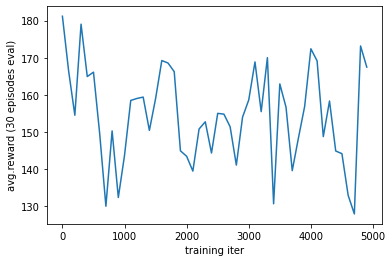

In [26]:
x = np.arange(0, training_iters, args.save_freq)
y = evaluations
plt.plot(x, y)
plt.ylabel('avg.reward (30 episodes eval)')
plt.xlabel('training iter')

## Evaluate

In [50]:
import os
import imageio
import numpy as np
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt    

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)

    drawer = ImageDraw.Draw(im)

    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

    return im


def save_agent_gif(env, random=False, fname='agent.gif', n_iter = 5):
    frames = []
    for i in range(n_iter):
        state = env.reset()        
        for t in range(5000):
            
            if random:
                action = env.action_space.sample()
            else:
                action = best_policy.select_action(state)

            frame = env.render(mode='rgb_array')
            frames.append(_label_with_episode_number(frame, episode_num=i))

            state, _, done, _ = env.step(action)
            if done:
                break

    env.close()
    imageio.mimwrite(os.path.join(folder_name, fname), frames, fps=30)

## Results Dictionary

In [78]:
results_ = dict(
    env_type = [],
    wind_power = [],
    turb_power = [],
    agent_type = [],
    avg_reward = []
)

## Define Env - same parameters used to generate data

### Random Agent

In [79]:
#Eval
env.reset()
info = eval_policy(best_policy, env, eval_episodes=30, random=True)

results_['env_type'] += ['baseline']
results_['agent_type'] += ['random']
results_['wind_power'] += [5]
results_['turb_power'] += [1]
results_['avg_reward'] += [info['AverageReturn']]

---------------------------------------
Evaluation over 30 episodes: -278.561
---------------------------------------


In [80]:
# env.reset()
# save_agent_gif(env, random=True, fname='random_baseline.gif', n_iter=10)

env.reset()
save_agent_gif(env, random=True, fname='../../report_files/random_baseline.gif', n_iter=10)

### Trained agent

In [ ]:
#Eval
env.reset()
info = eval_policy(best_policy, env, eval_episodes=30)

results_['env_type'] += ['baseline']
results_['agent_type'] += ['plas']
results_['wind_power'] += [5]
results_['turb_power'] += [1]
results_['avg_reward'] += [info['AverageReturn']]

In [ ]:
# env.reset()
# save_agent_gif(env, fname='plas_baseline.gif', n_iter=10)

env.reset()
save_agent_gif(env, fname='../../report_files/plas_baseline.gif', n_iter=10)

## Define Env - Tweaked parameters

In [ ]:
wind_powers = np.arange(0, 21, 5)
turb_powers = np.arange(0, 2.5, 0.5)

for w in wind_powers:
    for t in turb_powers:
        if w != 5 and t != 1: # this is the baseline
            w = np.around(w, 3)
            t = np.around(t, 3)
            
            print(f"w: {w} | t: {t}")
            print("================================")
            env = gym.make(
                "LunarLander-v2",
                continuous = True,
                gravity = -10.0,
                enable_wind = True,
                wind_power = w, # between 0 and 20
                turbulence_power = t, # between 0 and 2
            )

            # RANDOM
            env.reset()
            info = eval_policy(best_policy, env, eval_episodes=30, random=True)

            results_['env_type'] += ['out_of_dist']
            results_['agent_type'] += ['random']
            results_['wind_power'] += [w]
            results_['turb_power'] += [t]
            results_['avg_reward'] += [info['AverageReturn']]  
            
            env.reset()
            save_agent_gif(env, random=True, fname=f'../../report_files/random_w={w}_t={t}.gif', n_iter=10)  
            
            # PLAS
            env.reset()
            info = eval_policy(best_policy, env, eval_episodes=30, random=False)

            results_['env_type'] += ['out_of_dist']
            results_['agent_type'] += ['plas']
            results_['wind_power'] += [w]
            results_['turb_power'] += [t]
            results_['avg_reward'] += [info['AverageReturn']]  
            
            env.reset()
            save_agent_gif(env, random=False, fname=f'../../report_files/plas_w={w}_t={t}.gif', n_iter=10)              

## Save results

In [ ]:
df_results = pd.DataFrame(results_)
df_results

In [ ]:
df_results.to_csv("report_files/results.csv", index=False)